## Face and Facial Keypoint detection

After we've trained a neural network to detect facial keypoints, we can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, we'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that the net expects. This step will be similar to the `data_transform` we created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to the CNN.
3. Use the trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

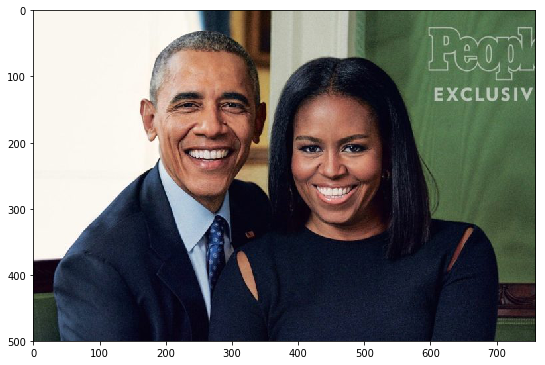

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, we'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in the selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). We can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


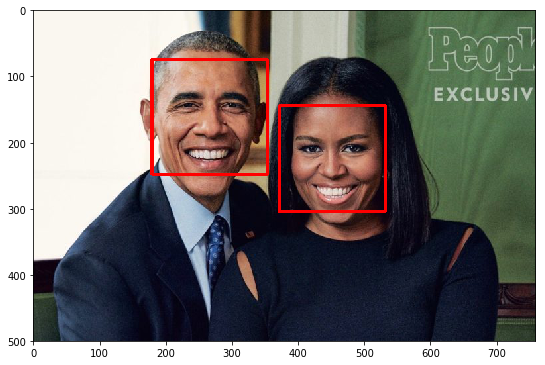

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once we have an image to work with (and, again, we can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into the CNN facial keypoint detector.

First, load your best model by its filename.

In [5]:
import torch
from models import Net

net = Net(out_size=136)

## Load the best saved model parameters (by your path name)
## Add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_0009.pt'))

## print out the net and prepare it for testing 
net.eval()

Net(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=135424, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2)
    (6): Linear(in_features=256, out_features=136, bias=True)
  )
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, we'll transform those faces in Tensors that your CNN can accept as input images.

### Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.


### Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, we can apply our `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [72]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [73]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i] # get the image from it's Variable wrapper

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*60+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts)
            
        plt.axis('off')

    plt.show()

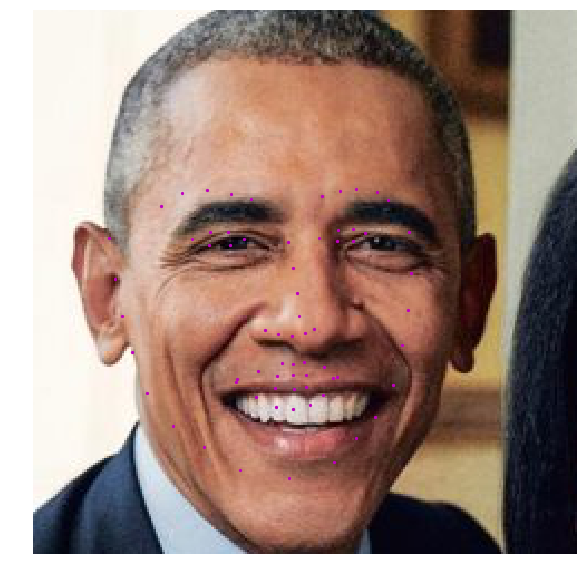

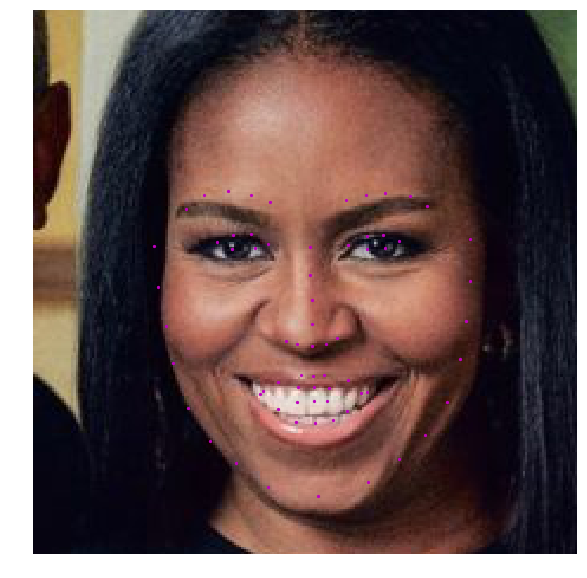

In [74]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image
    pad = 35
    roi = image_copy[y-pad:y+h+pad,x-pad:x+w+pad] #y-pad:y+h+pad,x-pad:x+w+pad   # y:y+h, x:x+w
    
    ## Convert the face region from RGB to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    gray = gray.astype('float32')/255.0
    
    ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    gray = cv2.resize(gray,(224,224))
    
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    gray = torch.from_numpy(gray).unsqueeze(2).permute(2, 0, 1).unsqueeze(0)
    
    ## Make facial keypoint predictions using your loaded, trained network
    predictions = net(gray)
    predictions = predictions.view(predictions.size()[0], 68, -1)
    
    ## Display each detected face and the corresponding keypoints        
    visualize_output(test_images=[roi], test_outputs=predictions, batch_size=1)
